In [96]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Model
import keras
from keras.regularizers import l2

# For Ordinal Encoding and standardising of the input
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
encoder = OrdinalEncoder()


# For recording history MSE values
from keras.callbacks import History 
history = History()

In [97]:
# Total dataset imported
dataset_total = pd.read_csv("ME504 ProcessedFinalData.csv", usecols=["Service Time(Years)", "MF_INVOLVED_TEXT", "LEAK_LOCATION_A_TEXT", "LEAK_LOCATION_B_TEXT", "LEAK_LOCATION_C_TEXT", "FITTING_MATERIAL_TEXT", "PIPE - 1 MATERIAL",	"PIPE - 2 MATERIAL",	"CAUSE OF LEAK", "LEAK_OCCURRED_TEXT", "PIPE - 1 DIA",	"PIPE - 2 DIA", "MF_TYPE_TEXT" ])
dataset_total.head()

,PIPE - 1 DIA,PIPE - 2 DIA,Service Time(Years),FITTING_MATERIAL_TEXT,PIPE - 1 MATERIAL,PIPE - 2 MATERIAL,MF_INVOLVED_TEXT,MF_TYPE_TEXT,LEAK_LOCATION_A_TEXT,LEAK_LOCATION_B_TEXT,LEAK_LOCATION_C_TEXT,CAUSE OF LEAK,LEAK_OCCURRED_TEXT
0,0.75,1.0,52,BRASS,COPPER,CAST/WROUGHT IRON,NUT FOLLOWER,COUPLING,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,EQUIPMENT,LEAKED THROUGH SEAL
1,2.00,4.0,29,PLASTIC,PLASTIC,PLASTIC,BOLTED,TAPPING TEE,BELOWGROUND,OUTSIDE,MAIN-TO-SERVICE,INCORRECT OPERATION,LEAKED THROUGH SEAL
2,4.00,1.0,23,PLASTIC,PLASTIC,PLASTIC,NUT FOLLOWER,COUPLING,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,EQUIPMENT,LEAKED THROUGH SEAL
3,0.75,1.5,51,STEEL,COPPER,COPPER,NUT FOLLOWER,COUPLING,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,EQUIPMENT,LEAKED THROUGH SEAL
4,1.50,3.0,37,STEEL,STEEL,PLASTIC,NUT FOLLOWER,COUPLING,BELOWGROUND,OUTSIDE,MAIN-TO-MAIN,EQUIPMENT,LEAKED THROUGH SEAL


In [98]:
# Separating Output Feature
Y_num = dataset_total[["Service Time(Years)"]].copy()
Y_num.head()

,Service Time(Years)
0,52
1,29
2,23
3,51
4,37


In [99]:
# Separating Input Variables
X = dataset_total[["MF_INVOLVED_TEXT",  "MF_TYPE_TEXT", "PIPE - 1 DIA", "PIPE - 2 DIA",  "PIPE - 1 MATERIAL",	"PIPE - 2 MATERIAL", "FITTING_MATERIAL_TEXT"]].copy() #"Altitude (m)", 
X.head()

,MF_INVOLVED_TEXT,MF_TYPE_TEXT,PIPE - 1 DIA,PIPE - 2 DIA,PIPE - 1 MATERIAL,PIPE - 2 MATERIAL,FITTING_MATERIAL_TEXT
0,NUT FOLLOWER,COUPLING,0.75,1.0,COPPER,CAST/WROUGHT IRON,BRASS
1,BOLTED,TAPPING TEE,2.00,4.0,PLASTIC,PLASTIC,PLASTIC
2,NUT FOLLOWER,COUPLING,4.00,1.0,PLASTIC,PLASTIC,PLASTIC
3,NUT FOLLOWER,COUPLING,0.75,1.5,COPPER,COPPER,STEEL
4,NUT FOLLOWER,COUPLING,1.50,3.0,STEEL,PLASTIC,STEEL


In [100]:
# Numerical Component of Input Variables
X_num  = X[["PIPE - 1 DIA"	,"PIPE - 2 DIA"]]
X_num.head()


# Standardizing Numerical Input Features
ss = StandardScaler()
X_num_std = ss.fit_transform(X_num)

In [101]:
# Categorrical Component of Input Variables
X_cat = X[["MF_INVOLVED_TEXT", "MF_TYPE_TEXT", "PIPE - 1 MATERIAL"	,"PIPE - 2 MATERIAL",	"FITTING_MATERIAL_TEXT"]].copy()
X_cat.head()

# Ordinal Encoding (Integers from 1 to n alloted to each Category) For Categorical Inputs (For Embedding Layer)
X_cat_enc = encoder.fit_transform(X_cat)

In [102]:
# For Counting no. of Different Categories to determine Embedding Layer Size
X_cat.value_counts()

MF_INVOLVED_TEXT                MF_TYPE_TEXT         PIPE - 1 MATERIAL  PIPE - 2 MATERIAL  FITTING_MATERIAL_TEXT        
NUT FOLLOWER                    COUPLING             STEEL              STEEL              STEEL                            859
BOLTED                          COUPLING             STEEL              STEEL              STEEL                            346
STAB                            COUPLING             PLASTIC            PLASTIC            PLASTIC                          343
NUT FOLLOWER                    COUPLING             STEEL              PLASTIC            STEEL                            333
                                SERVICE OR MAIN TEE  STEEL              STEEL              STEEL                            299
                                                                                                                           ... 
OTHER COMPRESSION TYPE FITTING  ADAPTER              COPPER             PLASTIC            COMBINATION PLASTIC 

In [103]:
# DEFINING THE MODEL


# Input Layers (4 for Categorical, 4 for numerical Input)
num_inputs = tf.keras.layers.Input((X_num.shape[1],  ), name = "num_input")

cat_inputs_a = tf.keras.layers.Input((1,  ), name = "cat_input_a")
cat_inputs_b = tf.keras.layers.Input((1,  ), name = "cat_input_b")
cat_inputs_c = tf.keras.layers.Input((1,  ), name = "cat_input_c")
cat_inputs_d = tf.keras.layers.Input((1,  ), name = "cat_input_d")
cat_inputs_e = tf.keras.layers.Input((1,  ), name = "cat_input_e")


# Embedding Layers Correcspoding to Each Feature  (Size for layers, Output features is Hard Coded As per Post-Processing Data)
cat_proc_a = tf.keras.layers.Embedding(7, 6, input_length = X_cat_enc.shape[1])(cat_inputs_a)
cat_proc_b = tf.keras.layers.Embedding(9, 8, input_length = X_cat_enc.shape[1])(cat_inputs_b)
cat_proc_c = tf.keras.layers.Embedding(9, 5, input_length = X_cat_enc.shape[1])(cat_inputs_c)
cat_proc_d = tf.keras.layers.Embedding(12, 11, input_length = X_cat_enc.shape[1])(cat_inputs_d)
cat_proc_e = tf.keras.layers.Embedding(12, 11, input_length = X_cat_enc.shape[1])(cat_inputs_e)

# Flattening the Output Tf Vector for Each layer for concatenation at later stage 
cat_proc_a = tf.keras.layers.Flatten()(cat_proc_a)
cat_proc_b = tf.keras.layers.Flatten()(cat_proc_b)
cat_proc_c = tf.keras.layers.Flatten()(cat_proc_c)
cat_proc_d = tf.keras.layers.Flatten()(cat_proc_d)
cat_proc_e = tf.keras.layers.Flatten()(cat_proc_e)


# Conctenating Embedding Layer Outputs with Numerical Inputs
x = tf.keras.layers.Concatenate( axis = -1)([num_inputs, cat_proc_a, cat_proc_b, cat_proc_c, cat_proc_d, cat_proc_e])


# SEQUENCTIAL MODEL POST COMPILING DIFFERNET INPUTS

x = tf.keras.layers.Dense(10, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)           # DropOut Layer to Minimize Overfitting
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization For Further Regularizing

x = tf.keras.layers.Dense(8, kernel_regularizer=l2(0.01) ,activation = 'relu')(x)   # Dense Layer with Weight Decay Enabled
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(9, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)      # DropOut Layer
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(5, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(7, kernel_regularizer=l2(0.05),activation = 'relu')(x)   # Weight Decay Enabled
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(Y_num.shape[1], activation = 'relu', name = 'output')(x)

In [109]:
# Compiling the Model and Resetting History
modelN = tf.keras.models.Model(
    inputs = [num_inputs, cat_inputs_a, cat_inputs_b, cat_inputs_c, cat_inputs_d, cat_inputs_e], 
    outputs = output)
modelN.compile(optimizer = keras.optimizers.Adam(lr = 0.001),
               loss = "mse",
               metrics = ["mse"])

# Resetting History
modelN.summary()
history = History()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input_a (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_b (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_c (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_d (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________________

In [110]:
# Fitting the model with spliced Categorical Inputs(Separated into 4) and Numerical Inputs
modelN.fit([ X_num_std, X_cat_enc[:, 0].reshape(-1, 1), X_cat_enc[:, 1].reshape(-1, 1), X_cat_enc[:, 2].reshape(-1, 1), X_cat_enc[:, 3].reshape(-1, 1), X_cat_enc[:, 4].reshape(-1, 1)],
           Y_num, batch_size= 10, epochs = 40, 
           validation_split=0.2,
           callbacks=[history]
           )

Epoch 1/40
961/961 [==============================] - 5s 3ms/step - loss: 1366.8240 - mse: 1366.4639 - val_loss: 317.5715 - val_mse: 317.2560
Epoch 2/40
961/961 [==============================] - 3s 3ms/step - loss: 296.1017 - mse: 295.7918 - val_loss: 80.6838 - val_mse: 80.3891
Epoch 3/40
961/961 [==============================] - 3s 3ms/step - loss: 149.7845 - mse: 149.4927 - val_loss: 56.6980 - val_mse: 56.4220
Epoch 4/40
961/961 [==============================] - 3s 3ms/step - loss: 114.9490 - mse: 114.6790 - val_loss: 39.3804 - val_mse: 39.1204
Epoch 5/40
961/961 [==============================] - 3s 3ms/step - loss: 110.2311 - mse: 109.9718 - val_loss: 42.6142 - val_mse: 42.3545
Epoch 6/40
961/961 [==============================] - 3s 3ms/step - loss: 108.6239 - mse: 108.3652 - val_loss: 30.7702 - val_mse: 30.5142
Epoch 7/40
961/961 [==============================] - 3s 3ms/step - loss: 90.3649 - mse: 90.1116 - val_loss: 29.8293 - val_mse: 29.5783
Epoch 8/40
961/961 [============

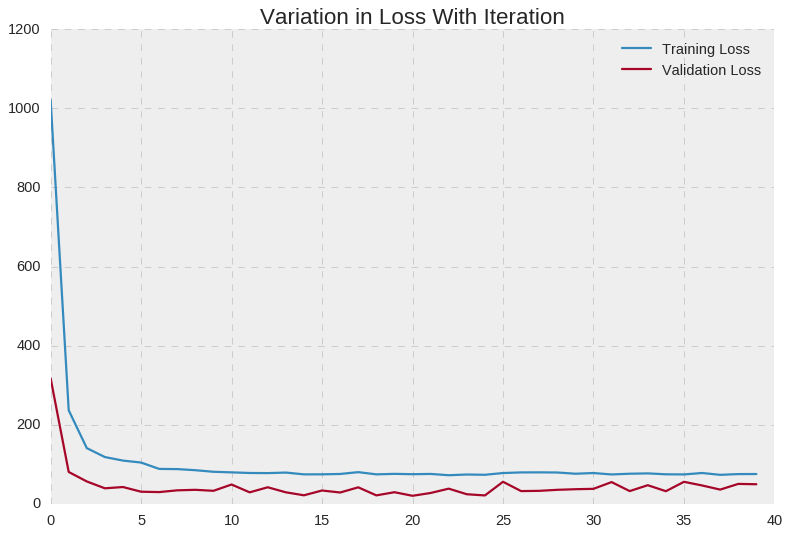

In [111]:
# MSE History Plot (Training Vs. Validation)
plt.style.use('bmh')
plt.plot(history.history['loss'], label =  "Training Loss")
plt.plot(history.history['val_loss'], label =  "Validation Loss")
plt.legend(loc='upper right', frameon = False)
plt.title("Variation in Loss With Iteration")
plt.show()

In [115]:
Y_pred = modelN.predict([ X_num_std, X_cat_enc[:, 0].reshape(-1, 1), X_cat_enc[:, 1].reshape(-1, 1), X_cat_enc[:, 2].reshape(-1, 1), X_cat_enc[:, 3].reshape(-1, 1), X_cat_enc[:, 4].reshape(-1, 1)])

##----------------------------------------------------------------------END--------------------------------------------------------------------------------
#### (Predicted Values printed Ahead)

In [ ]:
print(Y_pred[:, 0])

In [ ]:
Y_num.values[:, 0]